In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calmap
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import gc
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
import pandas as pd
from scipy.stats import bartlett, levene
import numpy as np
import pandas as pd
from scipy.stats import boxcox, bartlett, levene
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import plotly.express as px
import pandas as pd
import pandas as pd
import numpy as np
import plotly.graph_objects as go

In [ ]:
def reduce_mem_usage(df, verbose=False):
    start_mem = df.memory_usage().sum() / 1024 ** 2
    int_columns = df.select_dtypes(include=["int"]).columns
    float_columns = df.select_dtypes(include=["float"]).columns

    for col in int_columns:
        df[col] = pd.to_numeric(df[col], downcast="integer")

    for col in float_columns:
        df[col] = pd.to_numeric(df[col], downcast="float")

    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

In [286]:
calendar = pd.read_csv('calendar.csv').pipe(reduce_mem_usage, verbose=True)
calendar['date'] = pd.to_datetime(calendar['date'])
sales = pd.read_csv('sales_train_evaluation.csv').pipe(reduce_mem_usage, verbose=True)
sell_prices = pd.read_csv('sell_prices.csv').pipe(reduce_mem_usage, verbose=True)

Mem. usage decreased to  0.12 Mb (41.9% reduction)
Mem. usage decreased to 95.61 Mb (78.9% reduction)
Mem. usage decreased to 143.53 Mb (31.2% reduction)


# Functions

In [312]:
def process_sales_data(sales, calendar, sell_prices, dept_filter=None):
    """
    Process sales data by splitting identifiers, reshaping the data, 
    handling missing values, and creating relevant features.
    
    Parameters:
    sales (pd.DataFrame): The sales dataset containing item and store information.
    calendar (pd.DataFrame): The calendar dataset with event and date information.
    sell_prices (pd.DataFrame): The sell prices dataset.
    dept_filter (str, optional): The department ID to filter the sales data. If None, no filtering is applied.
    
    Returns:
    pd.DataFrame: Processed sales data.
    """
    
    # Split 'id' into multiple columns
    sales[['dept', 'item', 'store', 'dataset_type']] = sales['id'].str.split('_', n=3, expand=True)
    
    # Filter by department if specified
    if dept_filter:
        sales = sales[sales['dept_id'] == dept_filter].copy()
    
    # Add missing columns for specific days (from 1942 to 1969)
    for i in range(1942, 1970):
        sales[f'd_{i}'] = 0
    
    # Reshape data from wide to long format
    sales_by_date = pd.melt(
        sales,
        id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
        var_name='d',
        value_name='items_sold'
    ).merge(calendar, on='d', how='left') \
     .merge(sell_prices, on=['store_id', 'item_id', 'wm_yr_wk'], how='left')
    
    # Keep only relevant columns
    sales_by_date = sales_by_date[['id', 'date', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 
                                   'items_sold', 'weekday', 'wday', 'month', 'year', 'event_name_1', 
                                   'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 
                                   'snap_TX', 'snap_WI', 'sell_price']]
    
    # Process event name features
    sales_by_date['event_1_isna'] = sales_by_date['event_name_1'].notna().astype(int)
    sales_by_date['event_2_isna'] = sales_by_date['event_name_2'].notna().astype(int)
    sales_by_date['num_events'] = sales_by_date['event_1_isna'] + sales_by_date['event_2_isna']
    
    sales_by_date['event_name_1'] = sales_by_date['event_name_1'].fillna('no_event')
    sales_by_date['event_name_2'] = sales_by_date['event_name_2'].fillna('no_event')
    
    # Process SNAP features
    sales_by_date.loc[sales_by_date['state_id'] == 'CA', 'snap'] = sales_by_date.loc[sales_by_date['state_id'] == 'CA', 'snap_CA']
    sales_by_date.loc[sales_by_date['state_id'] == 'TX', 'snap'] = sales_by_date.loc[sales_by_date['state_id'] == 'TX', 'snap_TX']
    sales_by_date.loc[sales_by_date['state_id'] == 'WI', 'snap'] = sales_by_date.loc[sales_by_date['state_id'] == 'WI', 'snap_WI']
    
    sales_by_date['snap'] = sales_by_date['snap'].fillna(0).astype(int)
    
    # Add weekend feature
    sales_by_date['is_weekend'] = (sales_by_date['wday'] <= 2).astype(int)
    
    # Date format
    sales_by_date['date'] = pd.to_datetime(sales_by_date['date'])

    return sales_by_date

def test_variance_stability(series):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    midpoint = len(series) // 2
    first_half = series.iloc[:midpoint]
    second_half = series.iloc[midpoint:]
    
    bartlett_stat, bartlett_p = bartlett(first_half, second_half)
    levene_stat, levene_p = levene(first_half, second_half)
    
    results = pd.DataFrame({
        "Test": ["Bartlett’s Test", "Levene’s Test"],
        "Statistic": [bartlett_stat, levene_stat],
        "p-value": [bartlett_p, levene_p],
        "Variance Stable?": ["Yes" if p > 0.05 else "No" for p in [bartlett_p, levene_p]]
    })
    return results

def variance_test_table(daily_sales):
    # Ensure daily_sales is a pandas Series of floats
    if not isinstance(daily_sales, pd.Series):
        daily_sales = pd.Series(daily_sales)
    daily_sales = daily_sales.astype(float)
    
    # Original Series variance tests
    original_results = test_variance_stability(daily_sales)
    original_results["Transformation"] = "Original"
    
    # Log-Transformed Series variance tests
    log_transformed_sales = np.log1p(daily_sales)
    log_results = test_variance_stability(log_transformed_sales)
    log_results["Transformation"] = "Log-Transformed"
    
    # Box-Cox Transformation (requires strictly positive values)
    min_val = daily_sales.min()
    if min_val <= 0:
        shift = abs(min_val) + 0.1
        daily_sales_shifted = daily_sales + shift
    else:
        daily_sales_shifted = daily_sales.copy()
    
    # Apply Box-Cox on non-NaN values and wrap into a Series
    boxcox_transformed, fitted_lambda = boxcox(daily_sales_shifted.dropna().to_numpy(dtype=float))
    boxcox_series = pd.Series(boxcox_transformed, index=daily_sales_shifted.dropna().index)
    boxcox_results = test_variance_stability(boxcox_series)
    boxcox_results["Transformation"] = "Box-Cox"
    
    # Combine results into a single table
    combined_results = pd.concat([original_results, log_results, boxcox_results], ignore_index=True)
    combined_results = combined_results[["Transformation", "Test", "Statistic", "p-value", "Variance Stable?"]]
    
    # Optionally add the fitted lambda for Box-Cox as a separate row or note
    lambda_info = pd.DataFrame({
        "Transformation": ["Box-Cox (Lambda)"],
        "Test": [""],
        "Statistic": [fitted_lambda],
        "p-value": [""],
        "Variance Stable?": [""]
    })
    combined_results = pd.concat([combined_results, lambda_info], ignore_index=True)
    
    return combined_results

def plot_autocorrelation(daily_sales, max_lags=50):
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    plot_acf(daily_sales, lags=max_lags, ax=axes[0], title="Autocorrelation Function (ACF)")
    axes[0].set_xlabel("Lags")
    axes[0].set_ylabel("ACF Value")
    
    plot_pacf(daily_sales, lags=max_lags, ax=axes[1], title="Partial Autocorrelation Function (PACF)")
    axes[1].set_xlabel("Lags")
    axes[1].set_ylabel("PACF Value")
    
    plt.tight_layout()
    plt.show()

def plot_decomposition(daily_sales, model="additive", period=7):
    decomposition = seasonal_decompose(daily_sales, model=model, period=period)
    
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
    
    axes[0].plot(daily_sales, label="Original", color="blue", linewidth=1)
    axes[0].set_title("Original Series")
    axes[0].legend()
    
    axes[1].plot(decomposition.trend, label="Trend", color="red", linewidth=1)
    axes[1].set_title("Trend Component")
    axes[1].legend()
    
    axes[2].plot(decomposition.seasonal, label="Seasonality", color="green", linewidth=1)
    axes[2].set_title("Seasonal Component")
    axes[2].legend()
    
    axes[3].plot(decomposition.resid, label="Residuals", color="black", linewidth=1)
    axes[3].set_title("Residual Component")
    axes[3].legend()
    
    plt.tight_layout()
    plt.show()

def plot_sales_analysis(daily_sales):
    # Compute rolling standard deviation
    rolling_std = daily_sales.rolling(window=30, min_periods=1).std()
    
    # Convert sales to numpy array and apply log transformation
    daily_sales_values = daily_sales.to_numpy(dtype=float)
    log_sales = np.log1p(daily_sales_values)
    
    # Create 1 row, 3 columns of subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot rolling standard deviation
    axes[0].plot(daily_sales.index, rolling_std, label="Rolling Std Dev (30-day)", color="red")
    axes[0].set_xlabel("Date")
    axes[0].set_ylabel("Standard Deviation")
    axes[0].set_title("Rolling Std Dev (30-day)")
    axes[0].legend()
    axes[0].grid(True)
    
    # Plot distribution of sales
    sns.histplot(daily_sales, bins=50, kde=True, ax=axes[1])
    axes[1].set_xlabel("Sales")
    axes[1].set_ylabel("Frequency")
    axes[1].set_title("Distribution of Sales")
    axes[1].grid(True)
    
    # Plot log-transformed distribution of sales
    sns.histplot(log_sales, bins=50, kde=True, color="blue", ax=axes[2])
    axes[2].set_xlabel("Log-Transformed Sales")
    axes[2].set_ylabel("Frequency")
    axes[2].set_title("Log-Transformed Distribution of Sales")
    axes[2].grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_fft_power_spectrum(daily_sales, top_n_peaks=5):
    sns.set_style("whitegrid")

    sales_values = daily_sales.values
    n = len(sales_values)

    fft_values = np.fft.fft(sales_values)
    frequencies = np.fft.fftfreq(n)

    positive_freq_mask = frequencies > 0
    frequencies = frequencies[positive_freq_mask]
    power = np.abs(fft_values[positive_freq_mask])


    days_per_cycle = 1 / frequencies

    sorted_indices = np.argsort(power)[::-1]  # Sort descending
    dominant_periods = days_per_cycle[sorted_indices][:top_n_peaks]
    dominant_powers = power[sorted_indices][:top_n_peaks]

   
    plt.figure(figsize=(18, 6))
    plt.plot(days_per_cycle, power, marker="o", linestyle="-")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Days per Cycle (Log Scale)", fontsize=12)
    plt.ylabel("Power (Log Scale)", fontsize=12)
    plt.title("Power Spectrum Analysis using FFT", fontsize=14, fontweight="bold")
    plt.grid(True, linestyle="--", alpha=0.6)

    for period, power_val in zip(dominant_periods, dominant_powers):
        plt.axvline(period, color="red", linestyle="--")
        plt.text(period, power_val * 1.1, f"{int(period)} days", color="red", fontsize=12, ha="right")

    plt.show()

def plot_sales_trend(daily_sales):
    # Compute moving averages
    daily_sales_7d = daily_sales.rolling(window=7, min_periods=1).mean()
    daily_sales_30d = daily_sales.rolling(window=30, min_periods=1).mean()
    
    # Remove the last value to avoid cutoff issues
    daily_sales = daily_sales.iloc[:-1]
    daily_sales_7d = daily_sales_7d.iloc[:-1]
    daily_sales_30d = daily_sales_30d.iloc[:-1]
    
    # Set Seaborn style and color palette
    sns.set_style("whitegrid")
    palette = sns.color_palette("coolwarm", as_cmap=True)
    
    # Create the plot
    plt.figure(figsize=(15, 6))
    plt.plot(daily_sales, label="Daily Sales", alpha=0.3, color="gray", linestyle='dotted', linewidth=1.5)
    plt.plot(daily_sales_7d, label="7-day Moving Average", color="royalblue", linewidth=2.5)
    plt.plot(daily_sales_30d, label="30-day Moving Average", color="darkred", linewidth=2.5)
    
    plt.title("Sales Trend Over Time with Moving Averages", fontsize=16, fontweight='bold', pad=15)
    plt.xlabel("Date", fontsize=14, fontweight='bold', labelpad=10)
    plt.ylabel("Items Sold", fontsize=14, fontweight='bold', labelpad=10)
    plt.xticks(fontsize=12, rotation=20)
    plt.yticks(fontsize=12)
    plt.legend(frameon=True, fancybox=True, shadow=True, fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

def eda_group_analysis(df, groupby_col, 
                                show_time_series=True, 
                                show_summary=True, 
                                show_boxplots=True, 
                                show_correlation=True,
                                palette="Blues_r"):
    """
    Perform enhanced EDA for grouped sales analysis with customizable color palette.
    
    Parameters:
        df : pd.DataFrame
            DataFrame containing at least the columns 'date', 'items_sold',
            and the grouping column (e.g., 'state_id', 'store_id', or 'dept_id').
        groupby_col : str
            Column name to group by.
    """
    df['date'] = pd.to_datetime(df['date'])
    df['items_sold'] = pd.to_numeric(df['items_sold'], errors='coerce').fillna(0)
    
    results = {}
    
    # --- 1. Time Series Plot ----
    if show_time_series:
        ts = df.groupby(['date', groupby_col])['items_sold'].sum().reset_index()
        ts_pivot = ts.pivot(index='date', columns=groupby_col, values='items_sold')
        
        plt.figure(figsize=(15, 6))
        sns.set_style("whitegrid")

        groups = ts_pivot.columns
        colors = sns.color_palette(palette, n_colors=len(groups))
        
        for i, col in enumerate(groups):
            plt.plot(ts_pivot.index, ts_pivot[col], label=f"{groupby_col}: {col}",
                    color=colors[i], linewidth=2)
        
        plt.title(f"Time Series of Items Sold by {groupby_col}", fontsize=16, fontweight='bold')
        plt.xlabel("Date", fontsize=14)
        plt.ylabel("Items Sold", fontsize=14)
        plt.legend(title=groupby_col, fontsize=12)
        plt.grid(True, linestyle="--", alpha=0.6)
        plt.tight_layout()
        plt.show()

    # --- 2. Statistical Summaries ---
    summary = df.groupby(groupby_col)['items_sold'].describe().reset_index()
    results['summary'] = summary
    if show_summary:
        print(f"Statistical Summary by {groupby_col}:")
        print(summary.to_string(index=False))
    
    # --- 3. Boxplots & Histograms ---
    if show_boxplots:
        unique_groups = df[groupby_col].unique()
        n_groups = len(unique_groups)
        fig, axes = plt.subplots(n_groups, 2, figsize=(16, 5 * n_groups))
        if n_groups == 1:
            axes = np.array([axes])
        for i, group in enumerate(unique_groups):
            group_data = df[df[groupby_col] == group]['items_sold']
            
            sns.boxplot(x=group_data, ax=axes[i, 0], color="lightgreen", fliersize=3,
                        boxprops=dict(edgecolor="darkgreen", linewidth=1.5))
            axes[i, 0].set_title(f"Boxplot for {groupby_col}: {group}", fontsize=14, fontweight='bold')
            axes[i, 0].set_xlabel("Items Sold", fontsize=12)
            
            sns.histplot(group_data, bins=30, kde=True, ax=axes[i, 1], color="skyblue")
            axes[i, 1].set_title(f"Histogram for {groupby_col}: {group}", fontsize=14, fontweight='bold')
            axes[i, 1].set_xlabel("Items Sold", fontsize=12)
        plt.tight_layout()
        plt.show()
    
    # --- 4. Correlation Analysis ---
    if show_correlation:
        if not show_time_series:
            ts = df.groupby(['date', groupby_col])['items_sold'].sum().reset_index()
            ts_pivot = ts.pivot(index='date', columns=groupby_col, values='items_sold')
        corr_matrix = ts_pivot.corr()
        results['correlation'] = corr_matrix

        plt.figure(figsize=(8, 6))
        sns.heatmap(corr_matrix, annot=True, fmt=".2f", cbar=True)
        plt.title(f"Correlation Matrix of Time Series by {groupby_col}", fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()

    
    return results

def visualize_weekday_sales_data(weekday, items_sold, store_id):
    """
    Parameters:
    weekday (list): List of weekdays corresponding to sales data.
    items_sold (list): List of items sold on respective weekdays.
    store_id (str): Store ID for subplot title.
    """
    df = pd.DataFrame({'Weekday': weekday, 'Items Sold': items_sold})
    weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    df['Weekday'] = pd.Categorical(df['Weekday'], categories=weekday_order, ordered=True)
    df = df.sort_values('Weekday')

    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=df['Weekday'],
        y=df['Items Sold'],
        marker=dict(
            color=df['Items Sold'], 
            colorscale='ylgnbu', 
            showscale=False  
        ),
        name='Items Sold'
    ))

    fig.add_trace(go.Scatter(
        x=df['Weekday'],
        y=df['Items Sold'],
        mode='lines+markers',
        line=dict(color='black', width=2, dash='dash'),
        name='Trendline'
    ))

    fig.update_layout(
        title=f"Items Sold by Weekday - {store_id}",
        xaxis_title="Weekday",
        yaxis_title="Items Sold",
        template="plotly_white",
        hovermode="x unified",
        xaxis=dict(tickmode="array", tickvals=list(range(len(weekday_order))), ticktext=weekday_order)
    )

    return fig

def event_visualization( df,group_column,measure='items_sold',store_column='store_id',width=1200,height=1000):
    # Fill NaNs with a label so they appear as a category
    df[group_column] = df[group_column].fillna('Missing')

    # Compute daily average
    df_grouped = df.groupby([store_column, group_column])[measure].mean().reset_index()

    # Plot
    fig = px.bar(
        df_grouped,
        x=group_column,
        y=measure,
        color=group_column,
        animation_frame=store_column,
        animation_group=group_column,
        title=f"Daily Average {measure} by {group_column} for Each {store_column}"
    )
    
    fig.update_layout(
        width=width,
        height=height,
        title_text=f"Daily Average {measure} by {group_column} for Each {store_column}",
        xaxis_title=group_column,
        yaxis_title=f"Daily Average {measure}",
        hovermode="x unified"
    )
    
    fig.show()

def rolling_lag_corr_analysis(df,rolling_windows=[3, 7, 14, 30, 60, 90, 365, 328, 656],lags=[1, 7, 14, 30, 328, 656],corr_threshold=0.4):
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df_store = df.groupby(['store_id', 'date'])['items_sold'].sum().reset_index()

    for store in df_store['store_id'].unique():
        df_store.loc[df_store['store_id'] == store, 'store_items_sold'] = (
            df_store[df_store['store_id'] == store]['items_sold']
        )
        for window in rolling_windows:
            df_store.loc[df_store['store_id'] == store, f'rolling_mean_{window}'] = (
                df_store[df_store['store_id'] == store]['items_sold'].rolling(window).mean()
            )
            df_store.loc[df_store['store_id'] == store, f'rolling_std_{window}'] = (
                df_store[df_store['store_id'] == store]['items_sold'].rolling(window).std()
            )
        for lag in lags:
            df_store.loc[df_store['store_id'] == store, f'lag_{lag}'] = (
                df_store[df_store['store_id'] == store]['items_sold'].shift(lag)
            )

    df_store.dropna(inplace=True)
    store_ids = df_store['store_id'].unique()

    store_corr_dict = {}
    for store in store_ids:
        store_df = df_store[df_store['store_id'] == store].copy()
        correlation_features = (
            ['items_sold']
            + [f'rolling_mean_{w}' for w in rolling_windows]
            + [f'rolling_std_{w}' for w in rolling_windows]
            + [f'lag_{l}' for l in lags]
        )
        corr_matrix = store_df[correlation_features].corr()
        store_corr_dict[store] = corr_matrix

    fig = go.Figure()

    for i, store in enumerate(store_ids):
        corr_mat = store_corr_dict[store]
        trace_visible = (i == 0)
        fig.add_trace(
            go.Heatmap(
                z=corr_mat.values,
                x=corr_mat.columns,
                y=corr_mat.index,
                visible=trace_visible,
                colorscale='RdBu',
                zmid=0,
                colorbar=dict(title='Correlation', thickness=10)
            )
        )

    buttons = []
    for i, store in enumerate(store_ids):
        vis = [False] * len(store_ids)
        vis[i] = True
        buttons.append(
            dict(
                label=f"{store}",
                method="update",
                args=[
                    {"visible": vis},
                    {"title": f"Correlation Heatmap for Store {store}"}
                ]
            )
        )

    fig.update_layout(width=1200,height=800,margin=dict(l=80, r=160, t=80, b=100),updatemenus=[dict(active=0,buttons=buttons,x=1.3, xanchor='left',y=1.03,yanchor='top')],title={'text': f"Correlation Heatmap for Store {store_ids[0]}", 'x': 0.5, 'xanchor': 'center'}, xaxis_nticks=36)

    fig.update_xaxes(tickangle=90, tickfont=dict(size=10), automargin=True)
    fig.update_yaxes(automargin=True)

    fig.show()

    for store in store_ids:
        corr = store_corr_dict[store]
        if 'items_sold' in corr.columns:
            high_corr_features = corr['items_sold'][corr['items_sold'].abs() > corr_threshold].drop('items_sold', errors='ignore')
            print(f"\nStore ID: {store}")
            print(f"Highly Correlated Features (|correlation| > {corr_threshold}):")
            if high_corr_features.empty:
                print("None found above threshold.")
            else:
                print(high_corr_features.sort_values(ascending=False))

def process_store_df(df):
    df['date'] = pd.to_datetime(df['date'])
    aggregated_df = df.groupby('date', as_index=False).agg({
        'items_sold': 'sum',
        'event_name_1': 'first',
        'event_type_1': 'first',
        'event_name_2': 'first',
        'event_type_2': 'first',
        'snap_CA': 'first',
        'snap_TX': 'first',
        'snap_WI': 'first',
        'sell_price': 'mean',
        'event_1_isna': 'first',
        'event_2_isna': 'first',
        'num_events': 'first',
        'snap': 'first',
        'is_weekend': 'first'
    })

    aggregated_df = aggregated_df.drop(columns=['id', 'item_id', 'dept_id', 'store_id', 'state_id', 'weekday', 'year'], errors='ignore')
    aggregated_df.sort_values(by=['date'])
    
    aggregated_df['date'] = pd.to_datetime(aggregated_df['date'])
    aggregated_df = aggregated_df[aggregated_df['date'] <= '2016-05-22']
    return  aggregated_df

def create_lags(df):
    df = df.sort_values(by='date')

    rolling_windows = [3, 7, 14, 30, 60, 90]
    lag_periods = [1, 7, 14, 328]

    for window in rolling_windows:
        df[f'rolling_mean_{window}'] = df['items_sold'].rolling(window, min_periods=1).mean()

    for window in [30, 60, 90]:
        df[f'rolling_std_{window}'] = df['items_sold'].rolling(window, min_periods=1).std()

    for lag in lag_periods:
        df[f'lag_{lag}'] = df['items_sold'].shift(lag)

    df.fillna(0, inplace=True)

    return df

# Preprocess Data

In [ ]:
hobbies_sales_by_date = process_sales_data(sales, calendar, sell_prices, dept_filter="HOBBIES_1")
hobbies_sales_by_date.shape

C:\Users\wxiny\AppData\Local\Temp\ipykernel_8764\217154756.py:17: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\wxiny\AppData\Local\Temp\ipykernel_8764\217154756.py:17: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\wxiny\AppData\Local\Temp\ipykernel_8764\217154756.py:17: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented fra

(8207680, 25)

In [11]:
gc.collect()
del calendar, sell_prices, sales

In [288]:
hobbies_sales_by_date.to_pickle("hobbies_sales_by_date_raw.pkl")

# EDA

In [ ]:
hobbies_sales_by_date =pd.read_pickle('hobbies_sales_by_date_raw.pkl')

In [291]:
hobbies_sales_by_date = hobbies_sales_by_date.copy()
hobbies_sales_by_date['date'] = pd.to_datetime(df['date'])
hobbies_sales_by_date = hobbies_sales_by_date[hobbies_sales_by_date['date'] <= '2016-05-22']

## Time Series Visualizations  

### Time Series Trend

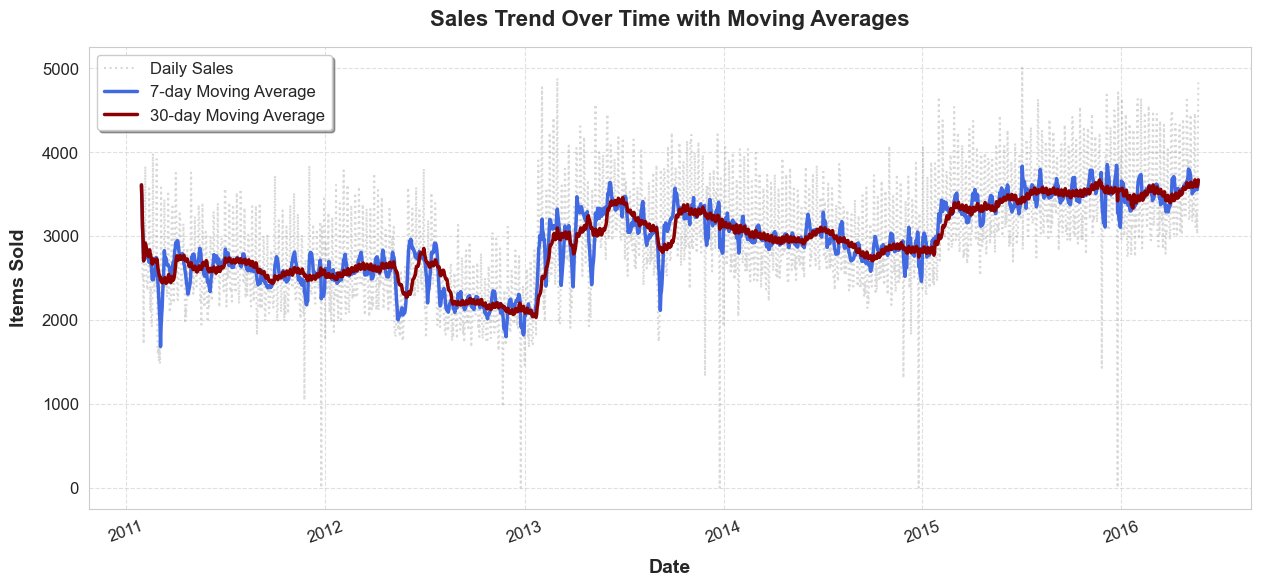

In [292]:
hobbies_sales_by_date.reset_index(inplace=True)
hobbies_sales_by_date['date'] = pd.to_datetime(hobbies_sales_by_date['date'])
daily_sales = hobbies_sales_by_date.groupby('date')['items_sold'].sum()
plot_sales_trend(daily_sales)


### Autocorrelation Analysis 

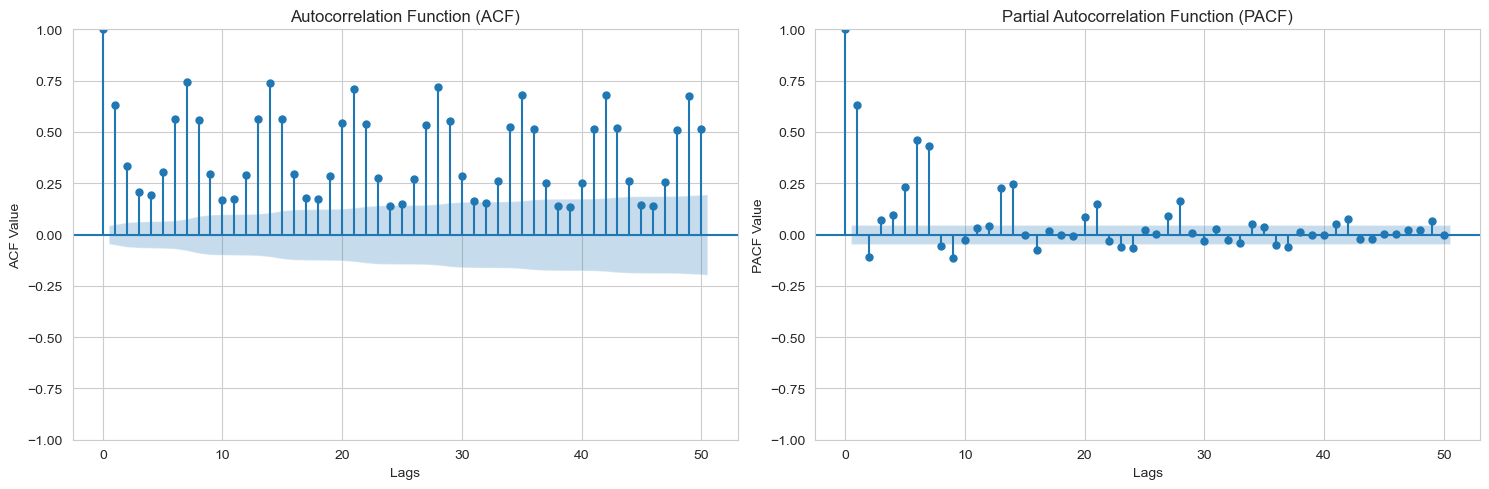

In [296]:
daily_sales = hobbies_sales_by_date.groupby('date')['items_sold'].sum()
plot_autocorrelation(daily_sales, max_lags=50)

### Decomposition Analysis

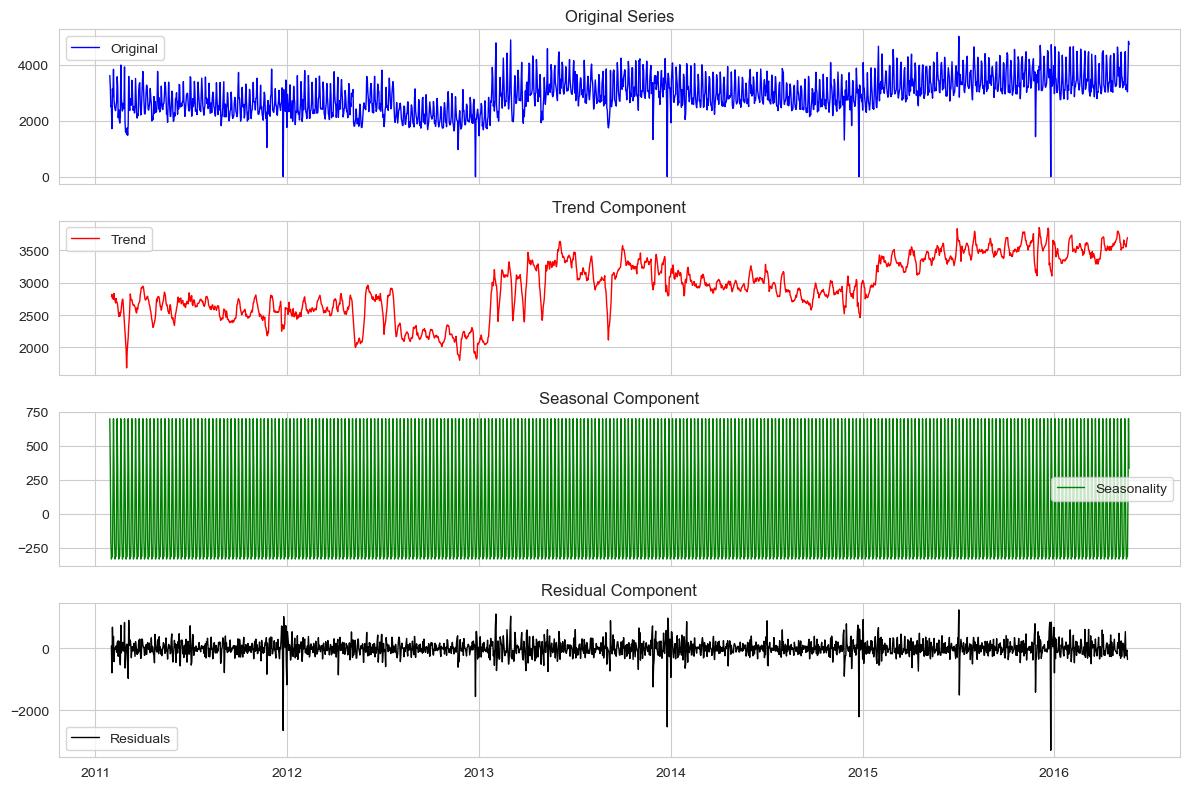

In [297]:
plot_decomposition(daily_sales, model="additive", period=7)

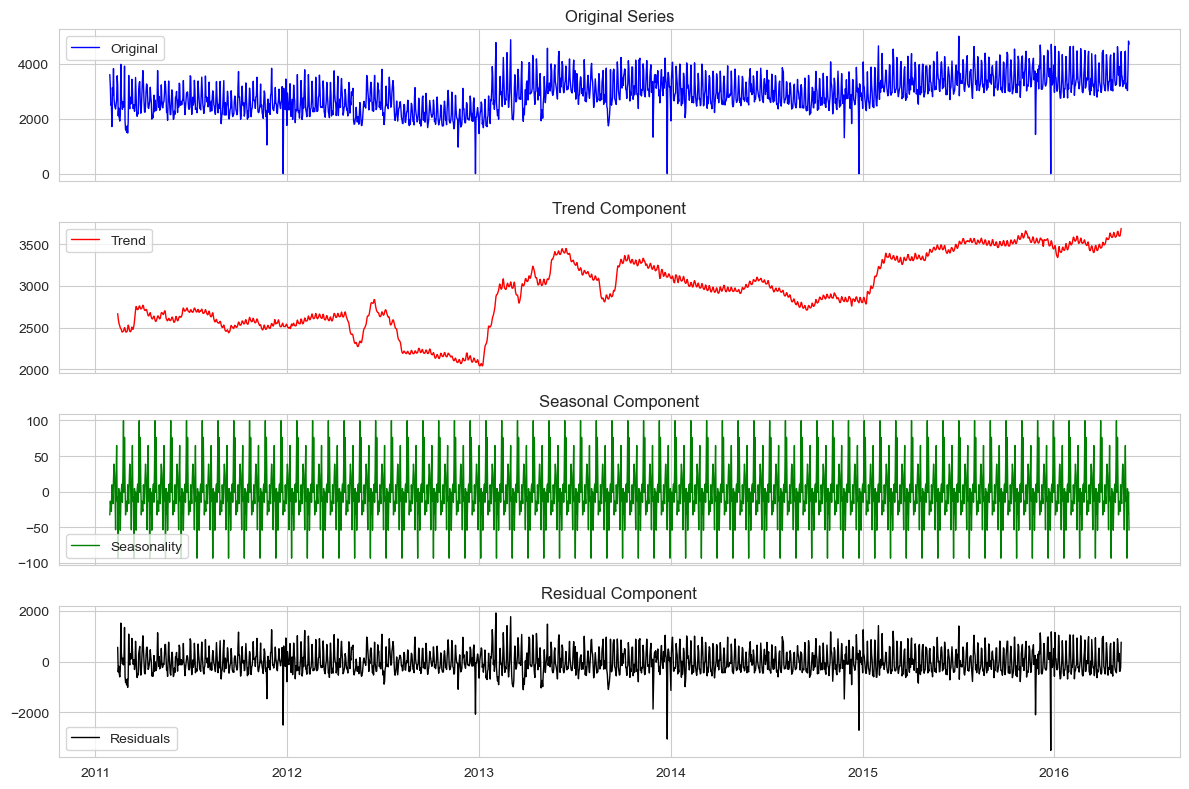

In [294]:
plot_decomposition(daily_sales, model="additive", period=30)

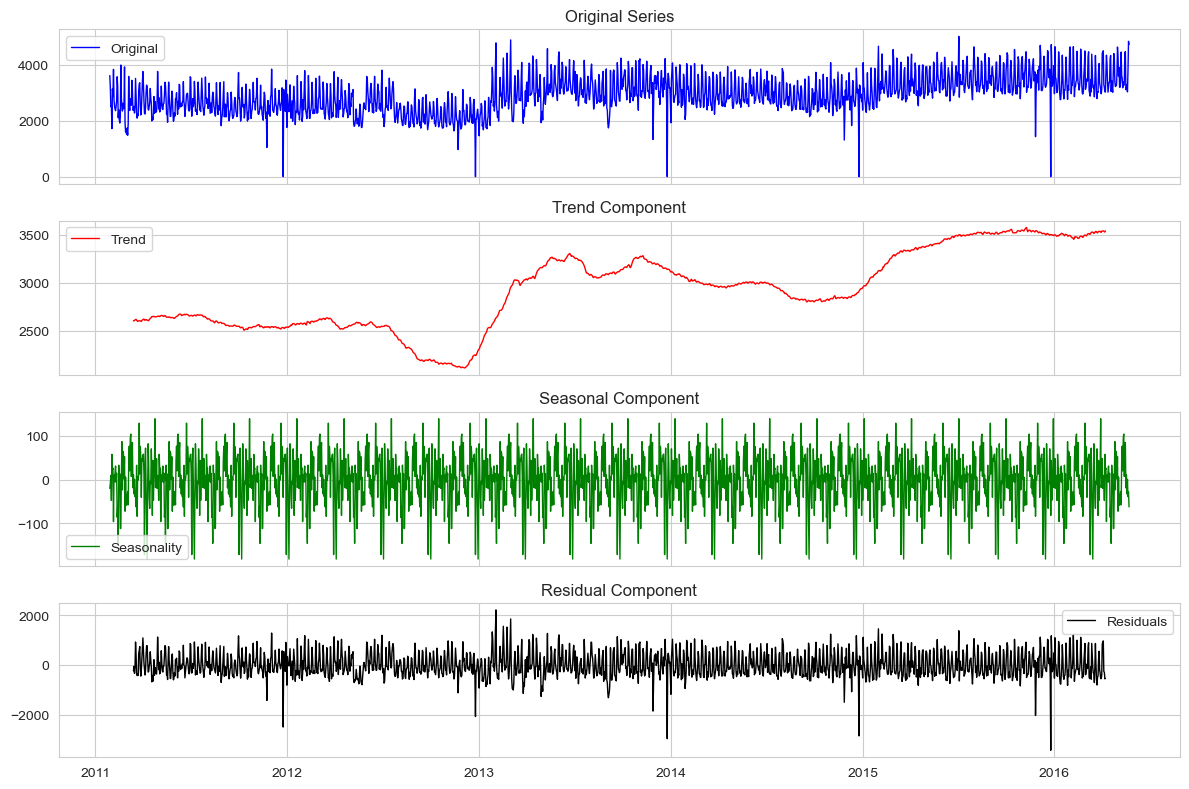

In [298]:
plot_decomposition(daily_sales, model="additive", period=90)

Because the time series shows significant weekly/monthly/quarterly seasonality, power spectrum analysis is used to see which has a greater effect.


### Power Spectrum Analysis

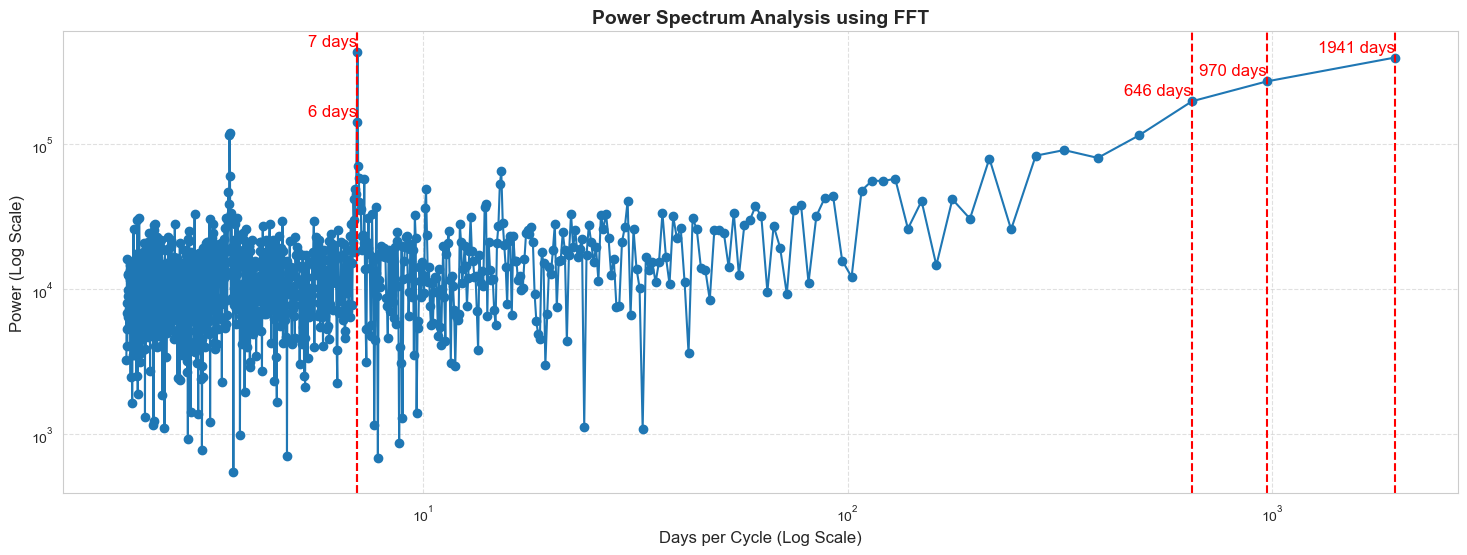

In [299]:
plot_fft_power_spectrum(daily_sales, top_n_peaks=5)

**The Fast Fourier Transform (FFT) power spectrum suggests that the time series contains multiple strong periodic components. Each peak corresponds to a dominant cycle in the data. Here are the main takeaways**:
- 6/7 Days
  - Indicates a weekly cycle, which is very common in retail, e-commerce, and many other business scenarios.
  - Often associated with weekend vs. weekday behavior or weekly purchasing patterns.

**Practical Implications**
- Model choice: Prophet can model yearly and weekly seasonality by default.
- SARIMA / SARIMAX: Can handle seasonal terms for one or two major seasonalities (like weekly or yearly), but multiple overlapping cycles can be cumbersome.
- Tree Models (LightGBM / XGBoost): Typically require feature engineering -— can create sine/cosine transformations for each dominant period.

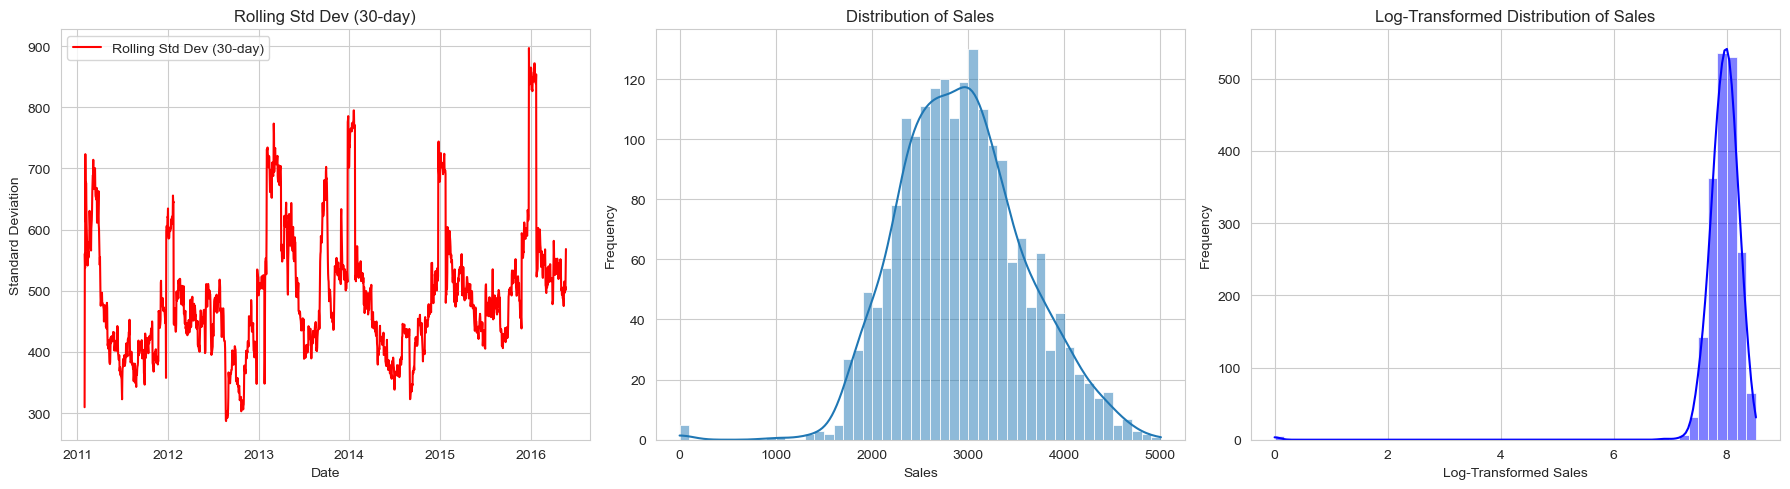

In [300]:
plot_sales_analysis(daily_sales)

### Variance Analysis

In [301]:

daily_sales = pd.Series(daily_sales)
test_variance_stability(daily_sales)
combined_table = variance_test_table(daily_sales)
print("Combined Variance Test Results:")
combined_table

Combined Variance Test Results:


,Transformation,Test,Statistic,p-value,Variance Stable?
0,Original,Bartlett’s Test,0.026020,0.871851,Yes
1,Original,Levene’s Test,0.037827,0.845812,Yes
2,Log-Transformed,Bartlett’s Test,20.675384,0.000005,No
3,Log-Transformed,Levene’s Test,1.706763,0.191561,Yes
4,Box-Cox,Bartlett’s Test,0.000388,0.984291,Yes
5,Box-Cox,Levene’s Test,0.186334,0.666033,Yes
6,Box-Cox (Lambda),,0.951514,,


## Group Analysis

### By State 

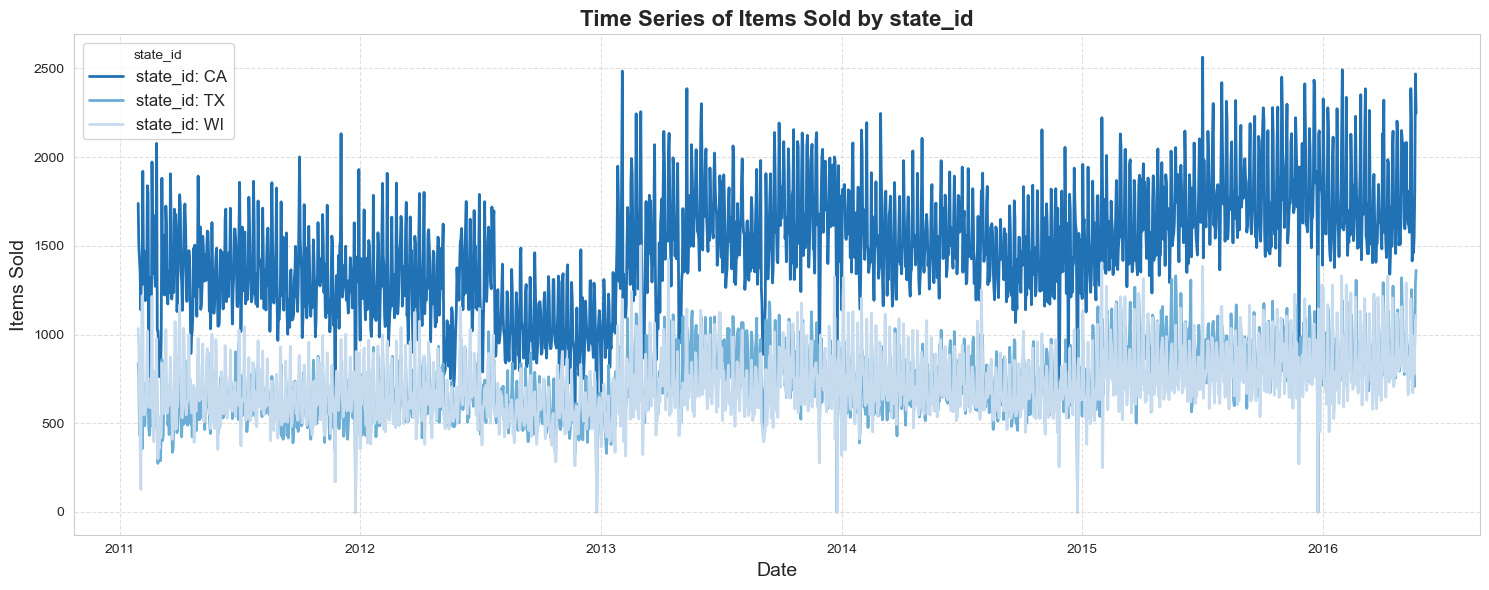

Statistical Summary by state_id:
state_id     count     mean      std  min  25%  50%  75%   max
      CA 3229824.0 0.890867 2.880870  0.0  0.0  0.0  1.0 294.0
      TX 2422368.0 0.591905 1.838570  0.0  0.0  0.0  1.0 183.0
      WI 2422368.0 0.572934 1.828395  0.0  0.0  0.0  0.0 259.0


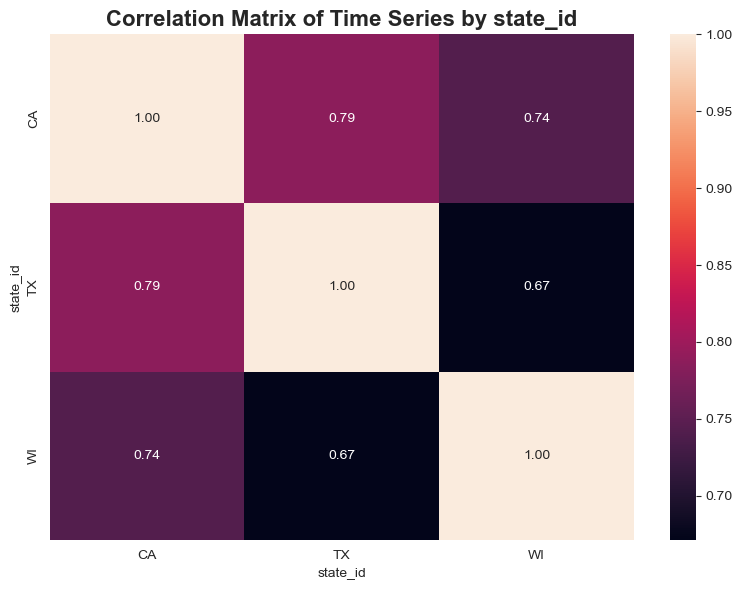

In [302]:
result = eda_group_analysis(hobbies_sales_by_date, groupby_col="state_id", show_time_series=True, show_summary=True, show_boxplots=False, show_correlation=True)

### By Store

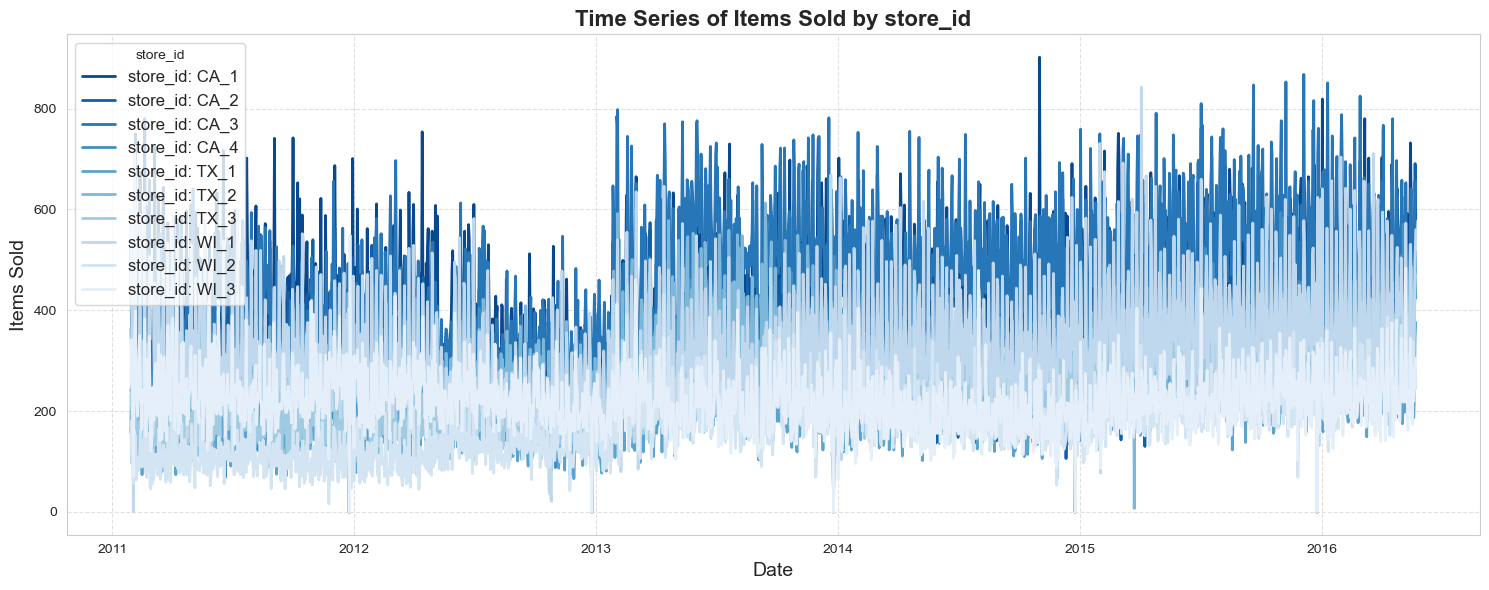

Statistical Summary by store_id:
store_id    count     mean      std  min  25%  50%  75%   max
    CA_1 807456.0 1.034828 3.238490  0.0  0.0  0.0  1.0 294.0
    CA_2 807456.0 0.729909 2.360009  0.0  0.0  0.0  1.0  97.0
    CA_3 807456.0 1.114701 3.453571  0.0  0.0  0.0  1.0 258.0
    CA_4 807456.0 0.684032 2.252453  0.0  0.0  0.0  0.0 160.0
    TX_1 807456.0 0.486881 1.674213  0.0  0.0  0.0  0.0 183.0
    TX_2 807456.0 0.706978 1.985598  0.0  0.0  0.0  1.0 124.0
    TX_3 807456.0 0.581856 1.836048  0.0  0.0  0.0  1.0 148.0
    WI_1 807456.0 0.766641 2.216517  0.0  0.0  0.0  1.0  94.0
    WI_2 807456.0 0.415986 1.476426  0.0  0.0  0.0  0.0  96.0
    WI_3 807456.0 0.536175 1.694935  0.0  0.0  0.0  0.0 259.0


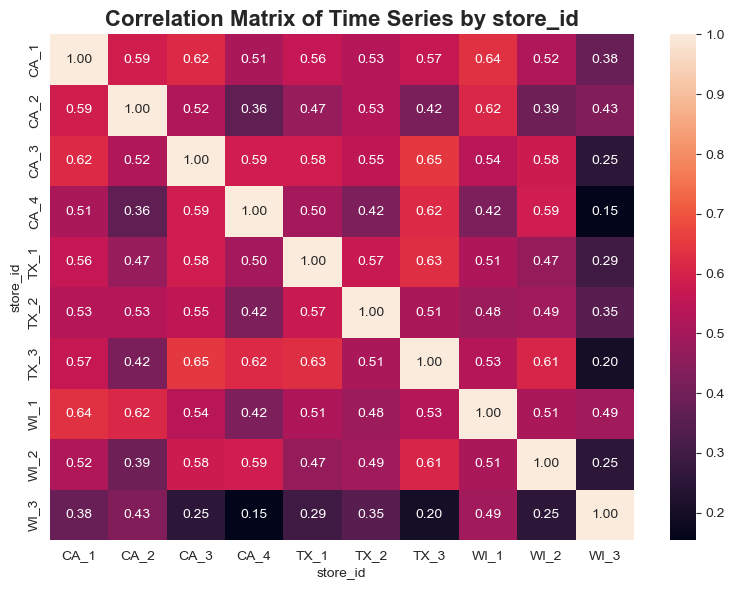

In [303]:
result = eda_group_analysis(hobbies_sales_by_date, groupby_col="store_id", show_time_series=True, show_summary=True, show_boxplots=False, show_correlation=True)

## Sales by weekday

In [304]:
sales_by_store = {store_id: hobbies_sales_by_date[hobbies_sales_by_date['store_id'] == store_id]for store_id in hobbies_sales_by_date['store_id'].unique()}
store_ids = ['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3']

In [305]:
for store_id in store_ids:
    daily_sales = sales_by_store[store_id].groupby('weekday')['items_sold'].sum()
    weekdays = daily_sales.index.tolist()
    sales = daily_sales.values.tolist()
    fig = visualize_weekday_sales_data(weekdays, sales, store_id)
    fig.show()


## Rolling Window & Lag Analysis

In [306]:
rolling_lag_corr_analysis(hobbies_sales_by_date, corr_threshold=0.3)


Store ID: CA_1
Highly Correlated Features (|correlation| > 0.3):
rolling_mean_3      0.720035
rolling_mean_7      0.551747
rolling_mean_14     0.507649
rolling_mean_30     0.503672
lag_14              0.486034
lag_7               0.465854
rolling_mean_60     0.455760
lag_1               0.435110
rolling_mean_90     0.426338
rolling_mean_328    0.313026
rolling_mean_365    0.303070
Name: items_sold, dtype: float64

Store ID: CA_2
Highly Correlated Features (|correlation| > 0.3):
rolling_mean_3     0.701929
lag_7              0.598082
lag_14             0.589811
rolling_mean_7     0.559732
rolling_mean_30    0.541781
rolling_mean_14    0.532795
rolling_mean_60    0.495391
rolling_mean_90    0.465099
lag_1              0.420835
rolling_std_30     0.406487
rolling_std_60     0.405697
rolling_std_90     0.397196
rolling_std_14     0.314056
Name: items_sold, dtype: float64

Store ID: CA_3
Highly Correlated Features (|correlation| > 0.3):
rolling_mean_3     0.695295
rolling_mean_7     0.5492

## Holidays Analysis

### Event1

In [307]:
event_visualization(hobbies_sales_by_date, 'event_type_1')

In [255]:
event_visualization(hobbies_sales_by_date, 'event_type_2')

In [308]:
event_visualization(hobbies_sales_by_date, 'event_1_isna')

### Event2

In [309]:
event_visualization(hobbies_sales_by_date, 'event_name_2')

In [258]:
event_visualization(hobbies_sales_by_date, 'event_type_2')

In [310]:
event_visualization(hobbies_sales_by_date, 'event_2_isna')